# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, TargetEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc

import xgboost as xgb

from sklearn.model_selection import GridSearchCV

import pickle
import requests

# 1.0. Data Preparation & Reading

In [2]:
df_raw = pd.read_csv('./data/salary.csv')

In [3]:
df_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df = df_raw.copy()

In [5]:
df.shape

(32561, 15)

In [6]:
df.columns = df.columns.str.lower().str.replace('-', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '')
    df[c] = df[c].str.replace('-','_')
    df[c] = df[c].replace('?', np.nan)

In [7]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,state_gov,77516,bachelors,13,never_married,adm_clerical,not_in_family,white,male,2174,0,40,united_states,<=50k
1,50,self_emp_not_inc,83311,bachelors,13,married_civ_spouse,exec_managerial,husband,white,male,0,0,13,united_states,<=50k
2,38,private,215646,hs_grad,9,divorced,handlers_cleaners,not_in_family,white,male,0,0,40,united_states,<=50k
3,53,private,234721,11th,7,married_civ_spouse,handlers_cleaners,husband,black,male,0,0,40,united_states,<=50k
4,28,private,338409,bachelors,13,married_civ_spouse,prof_specialty,wife,black,female,0,0,40,cuba,<=50k


In [8]:
df.salary.value_counts()

salary
<=50k    24720
>50k      7841
Name: count, dtype: int64

In [9]:
df.salary = (df.salary == '>50k').astype('int')

In [10]:
df.salary.value_counts()

salary
0    24720
1     7841
Name: count, dtype: int64

## 1.1. Data Cleaning

### 1.1.1 Checking Data Types

In [11]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
salary             int64
dtype: object

### 1.1.2 Checking for Missing Values

In [12]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
salary               0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary            0
dtype: int64

### 1.1.3 Checking for Duplicated Values

In [15]:
df.duplicated().sum()

np.int64(23)

In [16]:
df.drop_duplicates(keep='first', inplace=True)

In [17]:
df.duplicated().sum()

np.int64(0)

### 1.1.4 Checking for Data Imbalance

In [18]:
df.salary.value_counts(normalize=True)

salary
0    0.750954
1    0.249046
Name: proportion, dtype: float64

## 1.2. Spliting Data

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [20]:
len(df_train), len(df_val), len(df_test)

(18083, 6028, 6028)

In [21]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

In [22]:
y_train = X_train.salary.values
y_val = X_val.salary.values
y_test = X_test.salary.values

del X_train['salary']
del X_val['salary']
del X_test['salary']

# 2.0. Exploratory Data Analysis

In [23]:
df_full_train = df_full_train.reset_index(drop=True)

In [24]:
df_full_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary            0
dtype: int64

In [25]:
df_full_train.salary.value_counts(normalize=True)

salary
0    0.752685
1    0.247315
Name: proportion, dtype: float64

In [26]:
df_full_train.salary.mean()

np.float64(0.24731450375347352)

In [27]:
df_full_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
salary             int64
dtype: object

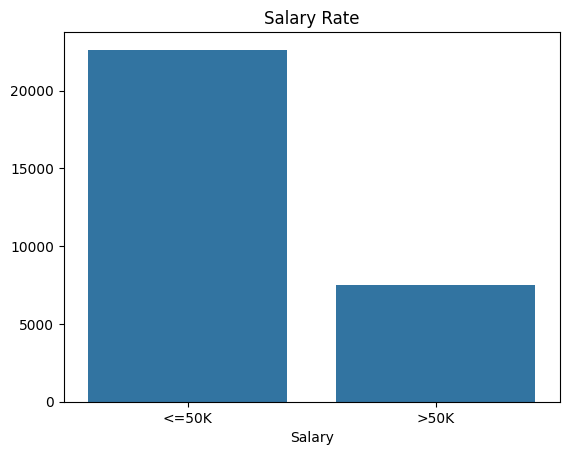

In [28]:
salary_counts = df['salary'].value_counts()
sns.barplot(x=salary_counts.index, y=salary_counts.values)

plt.title('Salary Rate')
plt.xlabel('Salary')
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.show()

In [63]:
df_full_train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,salary
count,24111.000000,2.411100e+04,24111.000000,24111.000000,24111.000000,24111.000000,24111.000000
mean,38.506491,1.898110e+05,10.118328,1057.039235,88.350587,40.914603,0.247315
std,13.167978,1.050143e+05,2.557115,7198.689632,404.074741,11.964615,0.431460
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176425e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784490e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.378285e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## 2.1. Categorical

In [29]:
cat_cols = ['workclass',
            'education',
            'marital_status',
            'occupation',
            'relationship',
            'race',
            'sex',
            'native_country'
            ]

In [30]:
df_full_train[cat_cols].nunique()

workclass          7
education         16
marital_status     7
occupation        14
relationship       6
race               5
sex                2
native_country    40
dtype: int64

### 2.1.1 Salary Ratio

In [31]:
global_salary = df_full_train.salary.mean()

In [32]:
def salary_rate_difference(df, column):
    salary_rate_by_column = df.groupby(column)['salary'].mean()
    salary_rate_diff = salary_rate_by_column - global_salary
    return salary_rate_diff.sort_values(ascending=False)

In [33]:
salary_rate_difference(df_full_train, 'workclass')

workclass
self_emp_inc        0.301798
federal_gov         0.150783
local_gov           0.044152
self_emp_not_inc    0.038758
state_gov           0.017618
private            -0.029850
without_pay        -0.247315
Name: salary, dtype: float64

In [34]:
salary_rate_difference(df_full_train, 'education')

education
prof_school     0.499812
doctorate       0.490550
masters         0.316011
bachelors       0.172983
assoc_voc       0.022588
assoc_acdm      0.002995
some_college   -0.051411
hs_grad        -0.084384
10th           -0.176098
12th           -0.177080
7th_8th        -0.181555
11th           -0.187102
9th            -0.188959
5th_6th        -0.207315
1st_4th        -0.223692
preschool      -0.247315
Name: salary, dtype: float64

In [35]:
salary_rate_difference(df_full_train, 'marital_status')

marital_status
married_civ_spouse       0.203814
married_af_spouse        0.181257
divorced                -0.142877
widowed                 -0.147315
married_spouse_absent   -0.152233
separated               -0.167929
never_married           -0.199368
Name: salary, dtype: float64

In [36]:
salary_rate_difference(df_full_train, 'occupation')

occupation
exec_managerial      0.232673
prof_specialty       0.199553
protective_serv      0.086019
tech_support         0.051107
sales                0.022965
craft_repair        -0.028963
transport_moving    -0.045368
adm_clerical        -0.110476
armed_forces        -0.122315
machine_op_inspct   -0.127770
farming_fishing     -0.133246
handlers_cleaners   -0.181621
other_service       -0.204291
priv_house_serv     -0.238840
Name: salary, dtype: float64

In [37]:
salary_rate_difference(df_full_train, 'relationship')

relationship
wife              0.249164
husband           0.203369
not_in_family    -0.141700
unmarried        -0.178932
other_relative   -0.207598
own_child        -0.231330
Name: salary, dtype: float64

In [38]:
salary_rate_difference(df_full_train, 'race')

race
asian_pac_islander    0.027890
white                 0.014973
amer_indian_eskimo   -0.116880
black                -0.120554
other                -0.160358
Name: salary, dtype: float64

In [39]:
salary_rate_difference(df_full_train, 'sex')

sex
male      0.063723
female   -0.132500
Name: salary, dtype: float64

In [40]:
salary_rate_difference(df_full_train, 'native_country').head(10)

native_country
taiwan        0.221435
iran          0.209828
italy         0.175762
cambodia      0.152685
india         0.150276
england       0.149511
france        0.143990
japan         0.132685
yugoslavia    0.127685
germany       0.095823
Name: salary, dtype: float64

### 2.1.2. Mutual Information

In [41]:
def mutual_info_salary_score(series):
    return mutual_info_score(series, df_full_train.salary)

In [42]:
mi = df_full_train[cat_cols].apply(mutual_info_salary_score)
mi.sort_values(ascending=False)

relationship      0.112616
marital_status    0.107306
education         0.064979
occupation        0.063503
sex               0.024997
workclass         0.011610
native_country    0.006656
race              0.005867
dtype: float64

## 2.2. Numerical

In [43]:
num_cols = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
    'salary'
]

### 2.2.1. Age

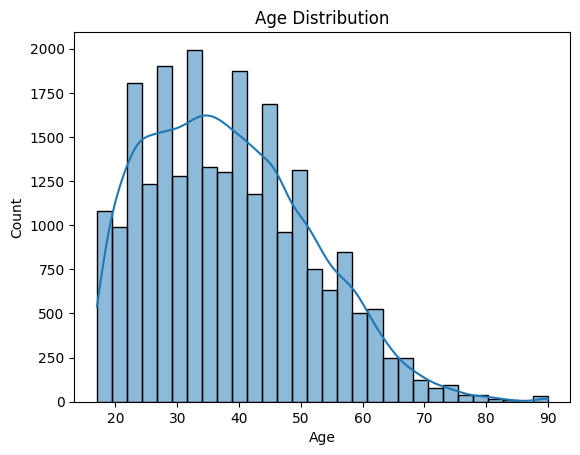

In [44]:
sns.histplot(df_full_train.age, bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

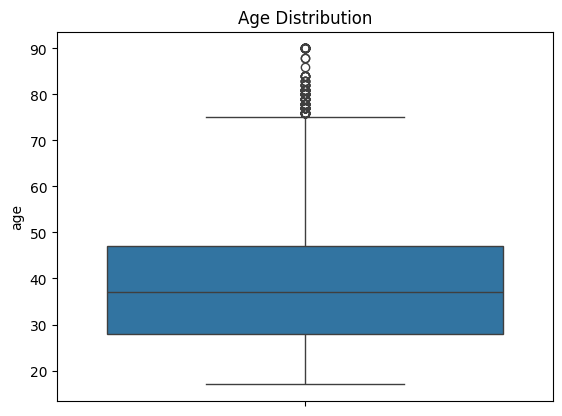

In [45]:
sns.boxplot(df_full_train.age)
plt.title('Age Distribution')
plt.show()

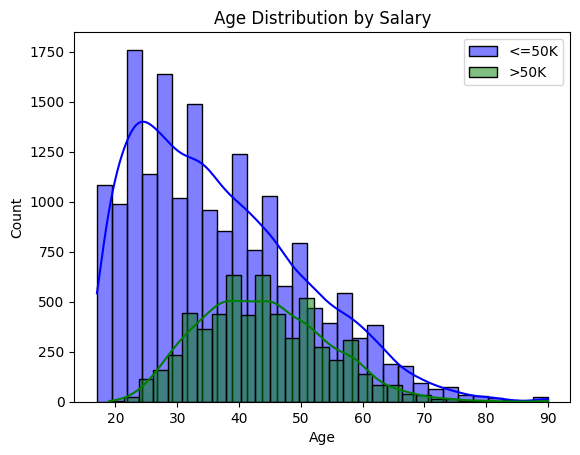

In [46]:
sns.histplot(df_full_train[df_full_train['salary'] == 0]['age'], bins=30, color='blue', label='<=50K', kde=True)
sns.histplot(df_full_train[df_full_train['salary'] == 1]['age'], bins=30, color='green', label='>50K', kde=True)

plt.title('Age Distribution by Salary')
plt.xlabel('Age')
plt.legend()
plt.show()

### 2.2.2. Fnlwgt

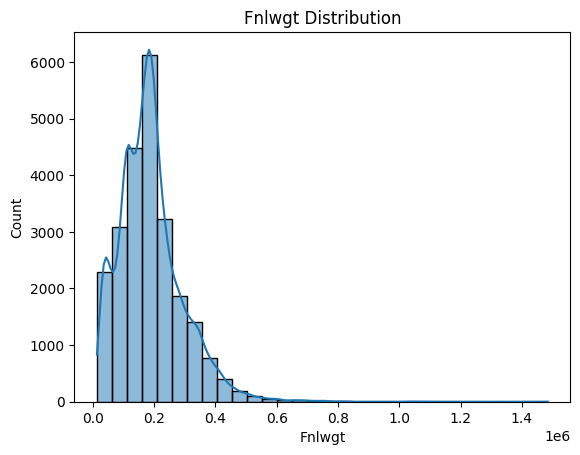

In [47]:
sns.histplot(df_full_train.fnlwgt, bins=30, kde=True)
plt.title('Fnlwgt Distribution')
plt.xlabel('Fnlwgt')
plt.show()

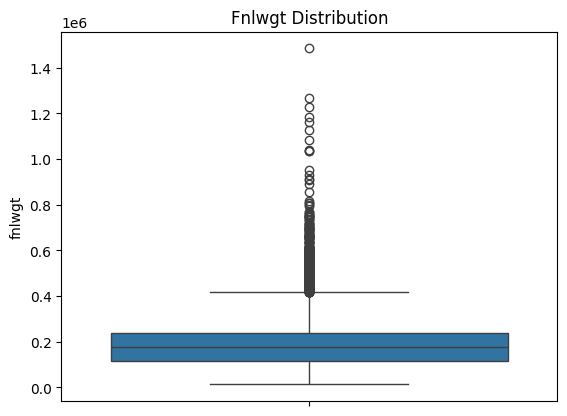

In [48]:
sns.boxplot(df_full_train.fnlwgt)
plt.title('Fnlwgt Distribution')
plt.show()

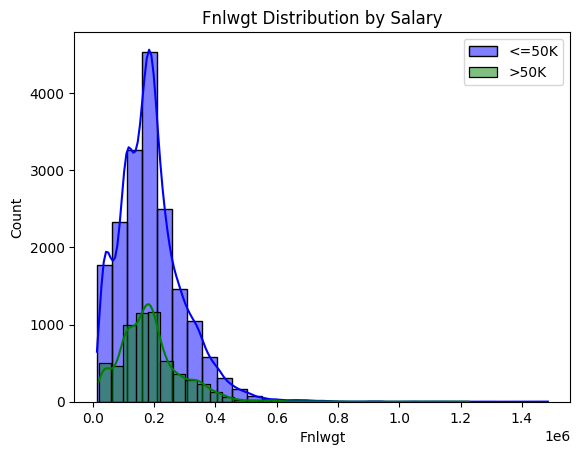

In [49]:
sns.histplot(df_full_train[df_full_train['salary'] == 0]['fnlwgt'], bins=30, color='blue', label='<=50K', kde=True)
sns.histplot(df_full_train[df_full_train['salary'] == 1]['fnlwgt'], bins=30, color='green', label='>50K', kde=True)

plt.title('Fnlwgt Distribution by Salary')
plt.xlabel('Fnlwgt')
plt.legend()
plt.show()

### 2.2.3. Education_num

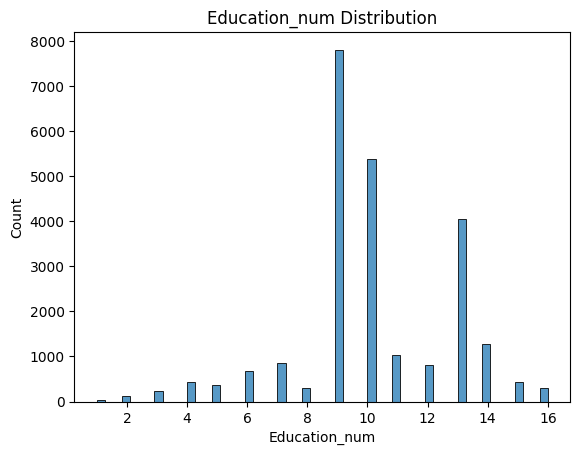

In [50]:
sns.histplot(df_full_train.education_num)
plt.title('Education_num Distribution')
plt.xlabel('Education_num')
plt.show()

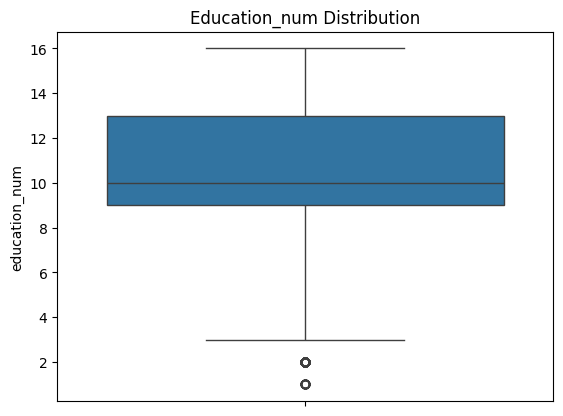

In [51]:
sns.boxplot(df_full_train.education_num)
plt.title('Education_num Distribution')
plt.show()

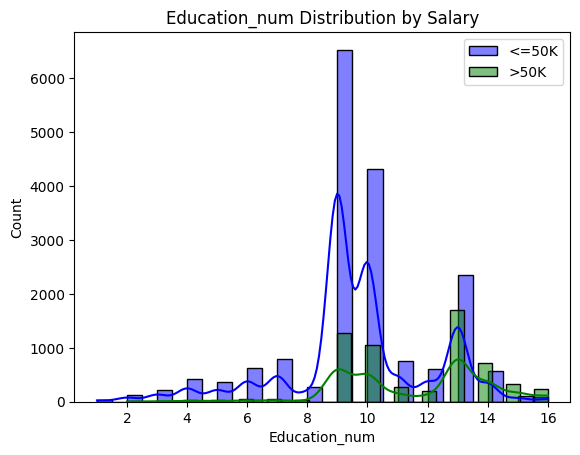

In [52]:
sns.histplot(df_full_train[df_full_train['salary'] == 0]['education_num'], bins=30, color='blue', label='<=50K', kde=True)
sns.histplot(df_full_train[df_full_train['salary'] == 1]['education_num'], bins=30, color='green', label='>50K', kde=True)

plt.title('Education_num Distribution by Salary')
plt.xlabel('Education_num')
plt.legend()
plt.show()

### 2.2.4 Capital_gain

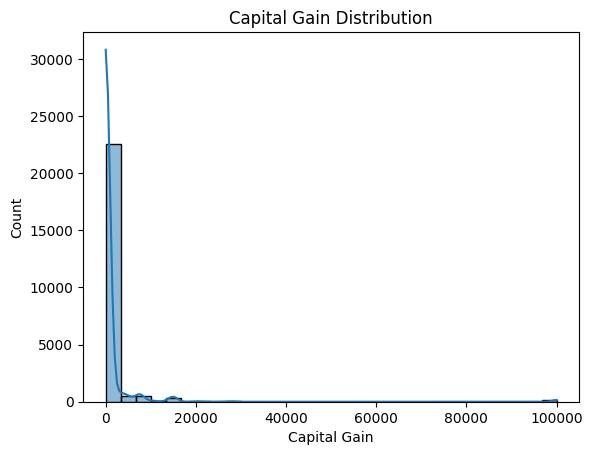

In [53]:
sns.histplot(df_full_train.capital_gain, bins=30, kde=True)
plt.title('Capital Gain Distribution')
plt.xlabel('Capital Gain')
plt.show()

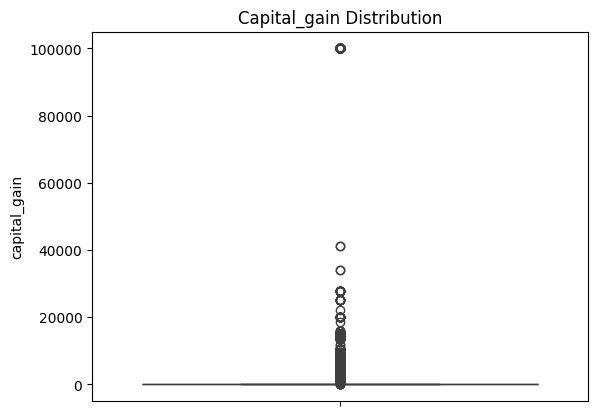

In [54]:
sns.boxplot(df_full_train.capital_gain)
plt.title('Capital_gain Distribution')
plt.show()

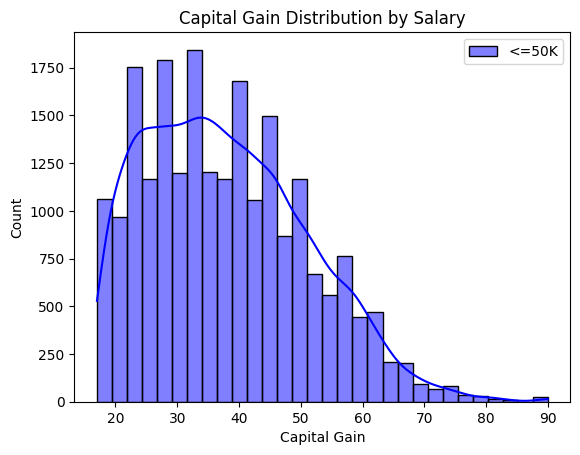

In [55]:
sns.histplot(df_full_train[df_full_train['capital_gain'] == 0]['age'], bins=30, color='blue', label='<=50K', kde=True)
sns.histplot(df_full_train[df_full_train['capital_gain'] == 1]['age'], bins=30, color='green', label='>50K', kde=True)

plt.title('Capital Gain Distribution by Salary')
plt.xlabel('Capital Gain')
plt.legend()
plt.show()

### 2.2.5. Capital_loss

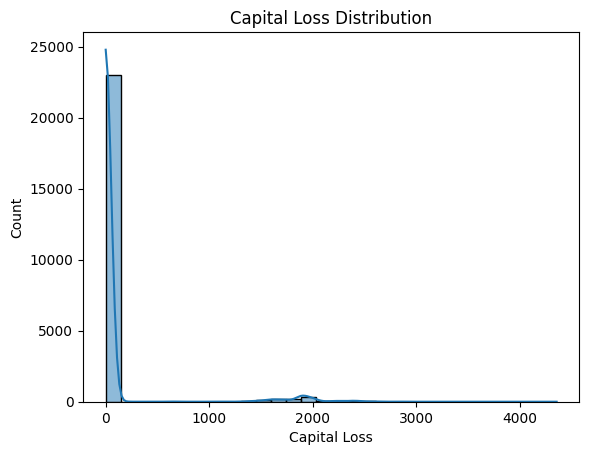

In [56]:
sns.histplot(df_full_train.capital_loss, bins=30, kde=True)
plt.title('Capital Loss Distribution')
plt.xlabel('Capital Loss')
plt.show()

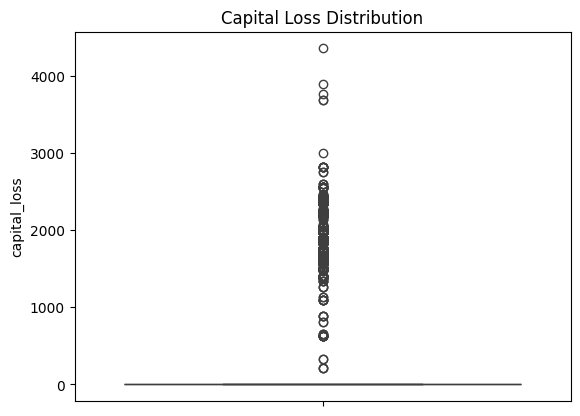

In [57]:
sns.boxplot(df_full_train.capital_loss)
plt.title('Capital Loss Distribution')
plt.show()

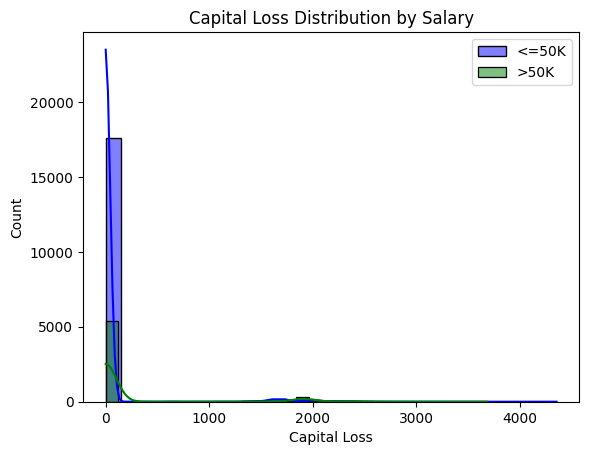

In [58]:
sns.histplot(df_full_train[df_full_train['salary'] == 0]['capital_loss'], bins=30, color='blue', label='<=50K', kde=True)
sns.histplot(df_full_train[df_full_train['salary'] == 1]['capital_loss'], bins=30, color='green', label='>50K', kde=True)

plt.title('Capital Loss Distribution by Salary')
plt.xlabel('Capital Loss')
plt.legend()
plt.show()

### 2.2.6. Hours Per Week

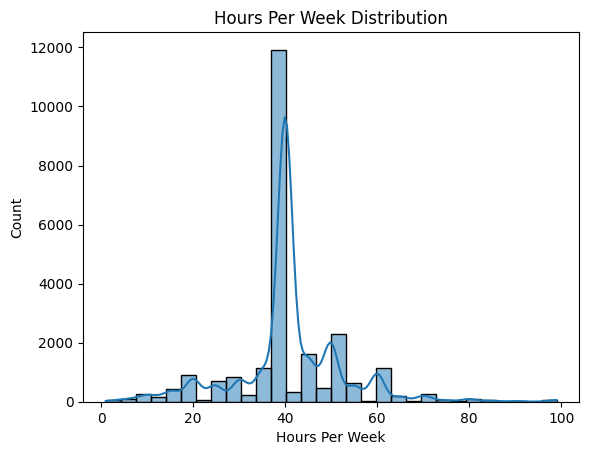

In [59]:
sns.histplot(df_full_train.hours_per_week, bins=30, kde=True)
plt.title('Hours Per Week Distribution')
plt.xlabel('Hours Per Week')
plt.show()

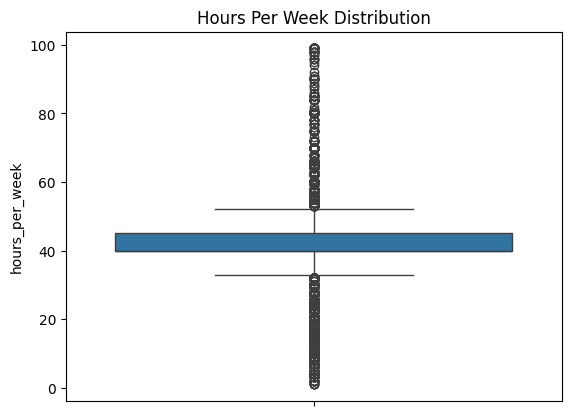

In [60]:
sns.boxplot(df_full_train.hours_per_week)
plt.title('Hours Per Week Distribution')
plt.show()

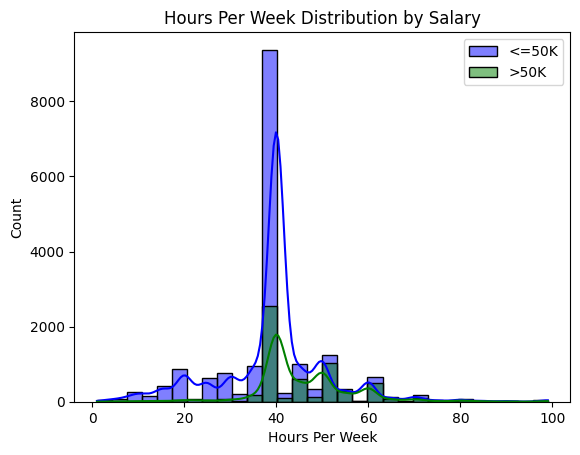

In [61]:
sns.histplot(df_full_train[df_full_train['salary'] == 0]['hours_per_week'], bins=30, color='blue', label='<=50K', kde=True)
sns.histplot(df_full_train[df_full_train['salary'] == 1]['hours_per_week'], bins=30, color='green', label='>50K', kde=True)

plt.title('Hours Per Week Distribution by Salary')
plt.xlabel('Hours Per Week')
plt.legend()
plt.show()

### 2.2.7. Heatmap

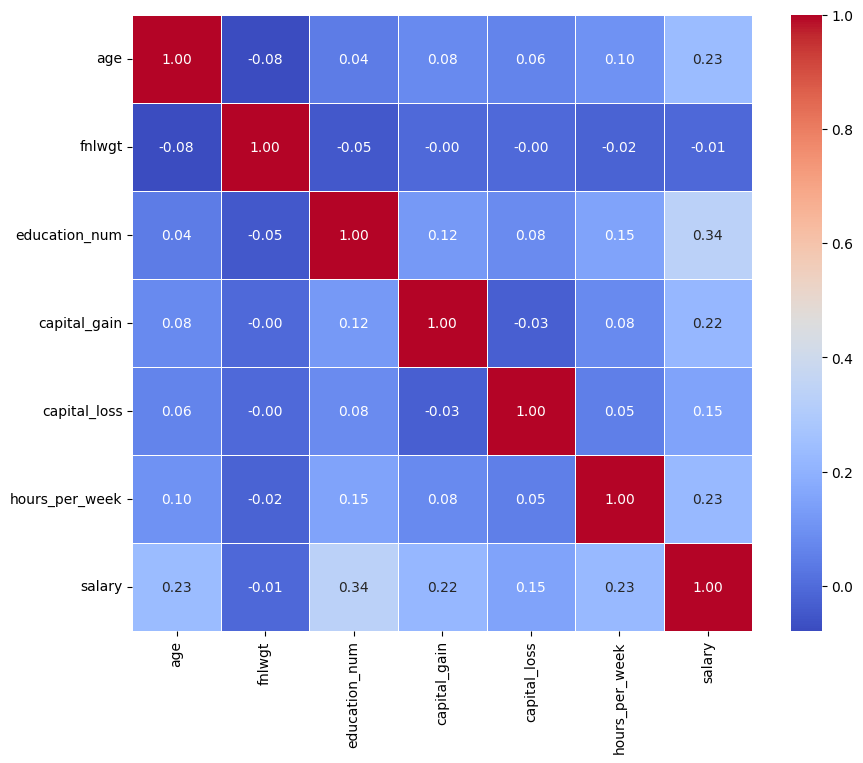

In [62]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_full_train[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

# 3.0. Model Selection

## 3.1. Encoding

In [223]:
categorical_cols = ['relationship', 'marital_status', 'education', 'occupation']
numerical_cols = ['hours_per_week', 'capital_loss', 'capital_gain', 'age', 'education_num']

education_order = [
    'preschool', 
    '1st_4th', 
    '5th_6th', 
    '7th_8th',
    '9th', 
    '10th', 
    '11th', 
    '12th',
    'hs_grad', 
    'some_college', 
    'assoc_acdm', 
    'assoc_voc', 
    'bachelors', 
    'masters', 
    'prof_school', 
    'doctorate'
]

In [224]:
relationship_ohe = OneHotEncoder(handle_unknown='ignore')
education_ord = OrdinalEncoder(categories=[education_order])
target_enc = TargetEncoder()
scaler = RobustScaler()

In [225]:
categorical_transformer = ColumnTransformer(transformers=[
    ('relationship_ohe', OneHotEncoder(handle_unknown='ignore'), ['relationship']),
    ('education_ord', OrdinalEncoder(categories=[education_order]), ['education']),
    ('marital_status_te', TargetEncoder(), ['marital_status']),
    ('occupation_te', TargetEncoder(), ['occupation'])
])

numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

## 3.2. Random Forest

In [68]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['hours_per_week',
                                                   'capital_loss',
                                                   'capital_gain', 'age',
                                                   'education_num']),
                                                 ('cat',
                                                  ColumnTransformer(transformers=[('relationship_ohe',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['relationship']),
                                                                                  ('education_ord',
                                                                                   OrdinalEncoder(categories=[['p...
                                                                                                               'assoc_acdm',
                                                                                                               'assoc_voc',
                                                                                                               'bachelors',
                                                                                                               'masters',
                                                                                                               'prof_school',
                                                                                                               'doctorate']]),
                                                                                   ['education']),
                                                                                  ('marital_status_te',
                                                                                   TargetEncoder(),
                                                                                   ['marital_status']),
                                                                                  ('occupation_te',
                                                                                   TargetEncoder(),
                                                                                   ['occupation'])]),
                                                  ['relationship',
                                                   'marital_status',
                                                   'education',
                                                   'occupation'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])

In [69]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

In [70]:
metrics_random_forest = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})

print(metrics_random_forest)

      Metric     Value
0   Accuracy  0.813039
1  Precision  0.581050
2     Recall  0.847561
3   F1-Score  0.689446


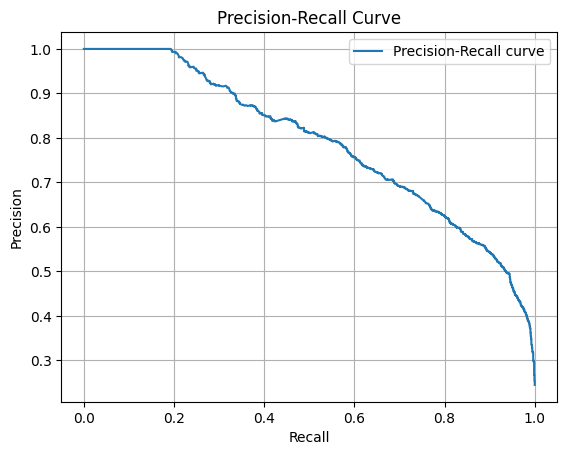

In [71]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

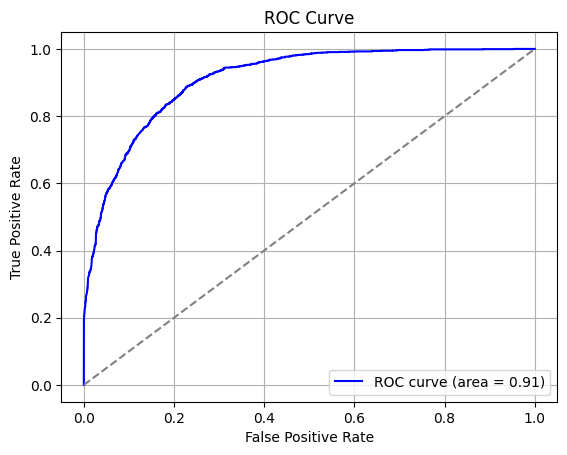

In [72]:
# roc curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [73]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # Teste com 50, 100 e 150 árvores
    'classifier__max_depth': [5, 10, 15],  # Teste com diferentes profundidades
    'classifier__min_samples_split': [2, 5],  # Teste com valores para a divisão dos nós
    'classifier__min_samples_leaf': [1, 2],  # Teste com valores para amostras mínimas nos nós folhas
    'classifier__max_features': ['sqrt', 'log2'],  # Corrigido para 'sqrt' e 'log2'
}


In [74]:
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='f1',
                           error_score='raise',
                           )

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("The best parameters are:", best_params)

best_model = grid_search.best_estimator_
validation_score = best_model.score(X_val, y_val)
print(f"Accuracy on the validation set is: {validation_score:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\pgdem\AppData\Local\pypoetry\Cache\virtualenvs\midterm-zYeBYxes-py3.10\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best parameters are: {'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Accuracy on the validation set is: 0.8306


In [75]:
y_pred = best_model.predict(X_val)
f1 = f1_score(y_val, y_pred)
print(f"The F1 score is: {f1:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"The ROC score is: {roc_auc:.4f}")

The F1 score is: 0.6989
The ROC score is: 0.9112


## 3.3. XGBoost

In [76]:
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    scale_pos_weight=3.04
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['hours_per_week',
                                                   'capital_loss',
                                                   'capital_gain', 'age',
                                                   'education_num']),
                                                 ('cat',
                                                  ColumnTransformer(transformers=[('relationship_ohe',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['relationship']),
                                                                                  ('education_ord',
                                                                                   OrdinalEncoder(categories=[['p...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [77]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

In [78]:
metrics_xgboost = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})

metrics_xgboost

,Metric,Value
0,Accuracy,0.827306
1,Precision,0.616372
2,Recall,0.780488
3,F1-Score,0.688789


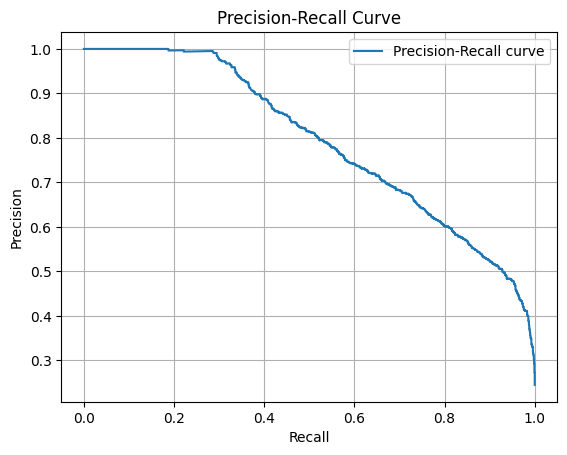

In [79]:
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

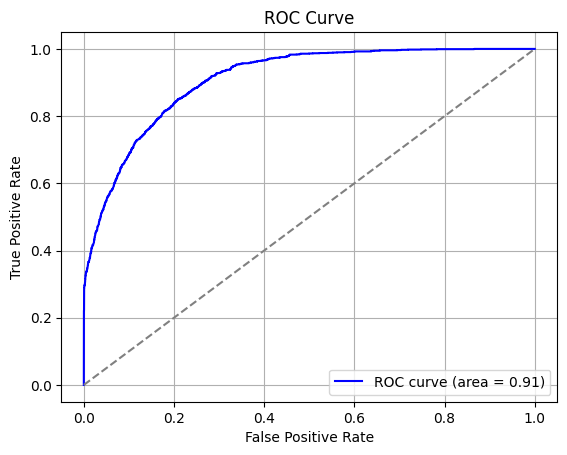

In [80]:
# roc curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [81]:
param_grid_xgb = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0]
}

In [82]:
grid_search_xgb = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_xgb, 
                               cv=5,
                               n_jobs=-1,
                               verbose=2,
                               scoring='f1',
                               error_score='raise')


grid_search_xgb.fit(X_train, y_train)


best_params_xgb = grid_search_xgb.best_params_
print("The best parameters found are:", best_params_xgb)

best_model_xgb = grid_search_xgb.best_estimator_
validation_score_xgb = best_model_xgb.score(X_val, y_val)
print(f"Accuracy on the validation set is: {validation_score_xgb:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
The best parameters found are: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Accuracy on the validation set is: 0.8296


c:\Users\pgdem\AppData\Local\pypoetry\Cache\virtualenvs\midterm-zYeBYxes-py3.10\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [83]:
y_pred = best_model_xgb.predict(X_val)
f1 = f1_score(y_val, y_pred)
print(f"The F1 score is: {f1:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"The ROC score is: {roc_auc:.4f}")

The F1 score is: 0.7060
The ROC score is: 0.9094


# 4.0. Model Saving and Loading

In [144]:
with open('xgboost_model_with_preprocessor.pkl', 'wb') as f:
    pickle.dump((best_model_xgb, preprocessor), f)

In [145]:
with open('xgboost_model_with_preprocessor.pkl', 'rb') as f:
    model, preprocessor = pickle.load(f)

### 4.1. Using Example

In [226]:
new_data = {
    'age': 31,
    'education': 'hs_grad',
    'education_num': 9,
    'marital_status': 'never_married',
    'occupation': 'craft_repair',
    'relationship': 'own_child',
    'capital_gain': 4101,
    'capital_loss': 0,
    'hours_per_week': 40
}

In [ ]:
new_data_df = pd.DataFrame([new_data])
prediction = model.predict(new_data_df)
print("Prediction:", prediction)

In [140]:
best_model_xgb.predict_proba(new_data_df)[0, 1]

np.float32(0.024542361)